<a href="https://colab.research.google.com/github/SavageGinny/AI-python/blob/main/%D0%9B%D0%B0%D0%B1%D0%B0_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# МЛ Практика 3: Подбор признаков и валидация моделей

## **Цель занятия:**
Изучить методы поиска значимых признаков в данных. На практике мы проведем анализ целевой переменной **Y**, применим методы для поиска значимых признаков, обучим линейную модель, проанализируем результат и оценим валидность модели.

## **Задание состоит из следующих частей:**
1. Обработка выбросов;
1. Поиск значимых признаков с использованием библиотеки **sklearn**.
2. Обучение логистической регресси модели и оценка ее точности.
6. Кросс-валидация с использованием разных методов (K-fold, ShuffleSplit, test-train-validation)

## 1: Загрузка библиотек и предобратка данных

In [1]:
!pip install pandas scikit-learn seaborn scipy

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.feature_selection import SelectKBest, chi2, RFE, SelectFromModel

In [3]:
# Загрузка набора данных
df = pd.read_csv('/content/pokemon.csv')

In [4]:
df

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,719,Diancie,Rock,Fairy,600,50,100,150,100,150,50,6,True
796,719,DiancieMega Diancie,Rock,Fairy,700,50,160,110,160,110,110,6,True
797,720,HoopaHoopa Confined,Psychic,Ghost,600,80,110,60,150,130,70,6,True
798,720,HoopaHoopa Unbound,Psychic,Dark,680,80,160,60,170,130,80,6,True


In [6]:
df['is_most_power_pokemon'] = np.where(df['Total'] >= 500, 1, 0)
df.is_most_power_pokemon = df.is_most_power_pokemon.astype('category')
df['Type 1'] = df['Type 1'].astype('category')

In [7]:
Y = df['is_most_power_pokemon'] # выбираем целевую переменную (категориальную)
X = df.drop('is_most_power_pokemon', axis=1) # переменные для проверки влияния

# В моем случае я дропаю базовую переменную, а не только. Y
X = X.drop('Total', axis=1)

Решил найти самых сильных покемонов. Мб далее посмотрим на примере сильнейших в какую стезю ориентируются те или инные стихии.

In [8]:
df.drop('Total', axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   #                      800 non-null    int64   
 1   Name                   800 non-null    object  
 2   Type 1                 800 non-null    category
 3   Type 2                 414 non-null    object  
 4   HP                     800 non-null    int64   
 5   Attack                 800 non-null    int64   
 6   Defense                800 non-null    int64   
 7   Sp. Atk                800 non-null    int64   
 8   Sp. Def                800 non-null    int64   
 9   Speed                  800 non-null    int64   
 10  Generation             800 non-null    int64   
 11  Legendary              800 non-null    bool    
 12  is_most_power_pokemon  800 non-null    category
dtypes: bool(1), category(2), int64(8), object(2)
memory usage: 65.8+ KB


In [9]:
df

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,is_most_power_pokemon
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False,0
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False,0
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False,1
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False,1
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,719,Diancie,Rock,Fairy,600,50,100,150,100,150,50,6,True,1
796,719,DiancieMega Diancie,Rock,Fairy,700,50,160,110,160,110,110,6,True,1
797,720,HoopaHoopa Confined,Psychic,Ghost,600,80,110,60,150,130,70,6,True,1
798,720,HoopaHoopa Unbound,Psychic,Dark,680,80,160,60,170,130,80,6,True,1


## 2: масштабирование признаков

In [10]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   #           800 non-null    int64   
 1   Name        800 non-null    object  
 2   Type 1      800 non-null    category
 3   Type 2      414 non-null    object  
 4   HP          800 non-null    int64   
 5   Attack      800 non-null    int64   
 6   Defense     800 non-null    int64   
 7   Sp. Atk     800 non-null    int64   
 8   Sp. Def     800 non-null    int64   
 9   Speed       800 non-null    int64   
 10  Generation  800 non-null    int64   
 11  Legendary   800 non-null    bool    
dtypes: bool(1), category(1), int64(8), object(2)
memory usage: 64.9+ KB


In [11]:
# Создаем копию данных
X_processed = X.copy()

category_columns: list[str] = X_processed.select_dtypes(include=['category']).columns # собираем колонки помеченные как category

# Применяем One-Hot Encoding
X_processed = pd.get_dummies(X_processed, columns=category_columns,drop_first=True) # drop_first=True позволяет избежать мультиколлинеарности, удаляя первый уровень категориальной переменной.


In [14]:
X_processed

,#,Name,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,...,Type 1_Ghost,Type 1_Grass,Type 1_Ground,Type 1_Ice,Type 1_Normal,Type 1_Poison,Type 1_Psychic,Type 1_Rock,Type 1_Steel,Type 1_Water
0,1,Bulbasaur,Poison,45,49,49,65,65,45,1,...,False,True,False,False,False,False,False,False,False,False
1,2,Ivysaur,Poison,60,62,63,80,80,60,1,...,False,True,False,False,False,False,False,False,False,False
2,3,Venusaur,Poison,80,82,83,100,100,80,1,...,False,True,False,False,False,False,False,False,False,False
3,3,VenusaurMega Venusaur,Poison,80,100,123,122,120,80,1,...,False,True,False,False,False,False,False,False,False,False
4,4,Charmander,NaN,39,52,43,60,50,65,1,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,719,Diancie,Fairy,50,100,150,100,150,50,6,...,False,False,False,False,False,False,False,True,False,False
796,719,DiancieMega Diancie,Fairy,50,160,110,160,110,110,6,...,False,False,False,False,False,False,False,True,False,False
797,720,HoopaHoopa Confined,Ghost,80,110,60,150,130,70,6,...,False,False,False,False,False,False,True,False,False,False
798,720,HoopaHoopa Unbound,Dark,80,160,60,170,130,80,6,...,False,False,False,False,False,False,True,False,False,False


In [16]:
# Выбираем числовые признаки
numeric_features = X_processed.select_dtypes(include=['int64']).columns.tolist()

# Инициализируем scaler
scaler = MinMaxScaler()

# Применяем нормализацию
X_processed[numeric_features] = scaler.fit_transform(X_processed[numeric_features])


Поменял Float64 на int64, так как именно этого типа у меня переменные

In [19]:
X_processed

,#,Name,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,...,Type 1_Ghost,Type 1_Grass,Type 1_Ground,Type 1_Ice,Type 1_Normal,Type 1_Poison,Type 1_Psychic,Type 1_Rock,Type 1_Steel,Type 1_Water
0,0.000000,Bulbasaur,Poison,0.173228,0.237838,0.195556,0.298913,0.214286,0.228571,0.0,...,False,True,False,False,False,False,False,False,False,False
1,0.001389,Ivysaur,Poison,0.232283,0.308108,0.257778,0.380435,0.285714,0.314286,0.0,...,False,True,False,False,False,False,False,False,False,False
2,0.002778,Venusaur,Poison,0.311024,0.416216,0.346667,0.489130,0.380952,0.428571,0.0,...,False,True,False,False,False,False,False,False,False,False
3,0.002778,VenusaurMega Venusaur,Poison,0.311024,0.513514,0.524444,0.608696,0.476190,0.428571,0.0,...,False,True,False,False,False,False,False,False,False,False
4,0.004167,Charmander,NaN,0.149606,0.254054,0.168889,0.271739,0.142857,0.342857,0.0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,0.997222,Diancie,Fairy,0.192913,0.513514,0.644444,0.489130,0.619048,0.257143,1.0,...,False,False,False,False,False,False,False,True,False,False
796,0.997222,DiancieMega Diancie,Fairy,0.192913,0.837838,0.466667,0.815217,0.428571,0.600000,1.0,...,False,False,False,False,False,False,False,True,False,False
797,0.998611,HoopaHoopa Confined,Ghost,0.311024,0.567568,0.244444,0.760870,0.523810,0.371429,1.0,...,False,False,False,False,False,False,True,False,False,False
798,0.998611,HoopaHoopa Unbound,Dark,0.311024,0.837838,0.244444,0.869565,0.523810,0.428571,1.0,...,False,False,False,False,False,False,True,False,False,False


## 3: Очистка данных и удаление выбросов

Важным шагом в машинном обучении - является очистка и удаление данных от выбросов.

### Методы обработки выбросов:

1. **Метод на основе медианы и межквартильного размаха (IQR)**:
   - **Как работает**:
     Метод основан на расчете межквартильного размаха (IQR), который вычисляется как разница между третьим (75-й перцентиль) и первым квартилем (25-й перцентиль). Данные считаются выбросами, если они выходят за пределы диапазона \([Q1 - 1.5 * IQR , Q3 + 1.5 * IQR]\).
   - **Зачем это нужно**:
     Выбросы могут серьезно искажать результаты моделей, особенно тех, которые основаны на средних значениях или предполагают нормальное распределение данных.
   - **Когда лучше использовать**:
     - Когда данные содержат **немного выбросов** и имеют **асимметричное распределение**.
     - Метод медианы и IQR более устойчив к выбросам по сравнению с методом, основанным на среднем значении, так как медиана меньше подвержена влиянию экстремальных значений.
     - Хорошо подходит для набора данных, которые не распределены нормально (например, зарплаты или цены на недвижимость).

2. **Метод на основе среднего (Mean)**:
   - **Как работает**:
     Метод использует средние значения и удаляет те признаки или записи, которые значительно отклоняются от среднего. Чаще всего это делается с помощью установления порога (например, данные, которые превышают 2 или 3 средних значения, считаются выбросами).
   - **Зачем это нужно**:
     Выбросы, сильно отличающиеся от средних значений, могут существенно влиять на такие модели, как линейная регрессия, так как среднее значение сильно чувствительно к экстремальным точкам.
   - **Когда лучше использовать**:
     - Когда данные имеют **нормальное распределение** или приближены к нормальному.
     - Подходит, если данные содержат **много выбросов**, и вам нужно жестче ограничить их влияние на модель.

### Как выбрать метод:

- **Если данные асимметричны** или распределены с "хвостами" (например, распределение доходов или цен), лучше использовать **метод на основе медианы и IQR**, так как медиана не чувствительна к выбросам и лучше описывает такие наборы данных.
  
- **Если данные нормально распределены** и важно учитывать всю выборку, даже если есть выбросы, можно использовать **метод на основе среднего**. Этот метод будет точнее отражать центр распределения в симметричных данных и позволит выявить значительные отклонения от него.

Оба метода помогают улучшить производительность моделей машинного обучения, обеспечивая более точное представление данных для анализа и обучения.

### Для начала определеим функцию обучения с оценкой качества (для простоты)

In [33]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

def train_and_evaluate(X, Y):
    # Меняю имена на числа
    label_encoder = LabelEncoder()
    for col in X.select_dtypes(include=['object', 'category']).columns:
        X[col] = label_encoder.fit_transform(X[col])
    # Разделение данных на обучающую и тестовую выборки
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.2, random_state=42, stratify=Y)
    # Инициализация модели
    model = LogisticRegression(max_iter=1000)

    # Обучение модели
    model.fit(X_train, Y_train)

    # Предсказания на обучающей выборке
    Y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(Y_train, Y_train_pred)

    # Предсказания на тестовой выборке
    Y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(Y_test, Y_test_pred)

    # Вывод результатов
    print(f"Точность на обучающей выборке: {train_accuracy:.4f}")
    print(f"Точность на тестовой выборке: {test_accuracy:.4f}")

    # Классификационный отчет
    print("\nКлассификационный отчет на тестовой выборке:")
    print(classification_report(Y_test, Y_test_pred))

    return model


При запуске выдавало ошибку преобразования string в float. Обратился к ChatGPT. При помощи Label Encoding преобразовал имена покемонов в числа.

In [43]:
train_and_evaluate(X_processed, Y)

Точность на обучающей выборке: 0.9375
Точность на тестовой выборке: 0.9062

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.88      1.00      0.94       111
           1       1.00      0.69      0.82        49

    accuracy                           0.91       160
   macro avg       0.94      0.85      0.88       160
weighted avg       0.92      0.91      0.90       160



LogisticRegression(max_iter=1000)

### Метод 1: удаление на основе медианы

In [35]:
# Функция для удаления выбросов на основе межквартильного размаха (1.5 IQR)
def remove_outliers_based_on_iqr(X, y, iqr_multiplier=1.5):
    # Убедимся, что работаем только с числовыми данными
    X_numeric = X.select_dtypes(include=['number'])

    # Рассчитываем первый и третий квартили для каждой числовой переменной
    Q1 = X_numeric.quantile(0.25)
    Q3 = X_numeric.quantile(0.75)

    # Вычисляем межквартильный размах (IQR)
    IQR = Q3 - Q1

    # Оставляем только те значения, которые находятся в диапазоне [Q1 - 1.5*IQR, Q3 + 1.5*IQR]
    X_filtered = X_numeric[~((X_numeric < (Q1 - iqr_multiplier * IQR)) | (X_numeric > (Q3 + iqr_multiplier * IQR))).any(axis=1)]

    # Синхронизируем y с отфильтрованными X
    y_filtered = y.loc[X_filtered.index]

    return X_filtered, y_filtered


In [36]:
X_iqr, y_iqr = remove_outliers_based_on_iqr(X_processed, Y, iqr_multiplier=3)

In [37]:
X_processed.describe()

,#,Name,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
count,800.000000,800.0000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,0.502519,399.5000,13.235000,0.268735,0.400007,0.305967,0.341413,0.247155,0.361586,0.464750
std,0.289366,231.0844,5.595213,0.100530,0.175445,0.138593,0.177839,0.132519,0.166060,0.332258
min,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.255208,199.7500,7.000000,0.192913,0.270270,0.200000,0.216033,0.142857,0.228571,0.200000
50%,0.504861,399.5000,16.500000,0.251969,0.378378,0.288889,0.298913,0.238095,0.342857,0.400000
75%,0.747569,599.2500,18.000000,0.311024,0.513514,0.377778,0.461957,0.333333,0.485714,0.800000
max,1.000000,799.0000,18.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [38]:
X_iqr.describe()

,#,Name,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
count,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000
mean,0.504081,399.685139,13.212846,0.266531,0.401035,0.304176,0.342569,0.245526,0.362929,0.466751
std,0.289816,230.269022,5.604564,0.092369,0.173687,0.131538,0.177727,0.129649,0.165745,0.332559
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.254514,201.250000,7.000000,0.192913,0.270270,0.200000,0.217391,0.142857,0.228571,0.200000
50%,0.509028,399.500000,16.000000,0.251969,0.378378,0.288889,0.298913,0.238095,0.342857,0.400000
75%,0.749653,597.750000,18.000000,0.311024,0.513514,0.377778,0.461957,0.333333,0.485714,0.800000
max,1.000000,799.000000,18.000000,0.665354,1.000000,0.866667,1.000000,0.857143,1.000000,1.000000


In [42]:
X_processed

,#,Name,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,...,Type 1_Ghost,Type 1_Grass,Type 1_Ground,Type 1_Ice,Type 1_Normal,Type 1_Poison,Type 1_Psychic,Type 1_Rock,Type 1_Steel,Type 1_Water
0,0.000000,80,13,0.173228,0.237838,0.195556,0.298913,0.214286,0.228571,0.0,...,False,True,False,False,False,False,False,False,False,False
1,0.001389,329,13,0.232283,0.308108,0.257778,0.380435,0.285714,0.314286,0.0,...,False,True,False,False,False,False,False,False,False,False
2,0.002778,745,13,0.311024,0.416216,0.346667,0.489130,0.380952,0.428571,0.0,...,False,True,False,False,False,False,False,False,False,False
3,0.002778,746,13,0.311024,0.513514,0.524444,0.608696,0.476190,0.428571,0.0,...,False,True,False,False,False,False,False,False,False,False
4,0.004167,102,18,0.149606,0.254054,0.168889,0.271739,0.142857,0.342857,0.0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,0.997222,160,4,0.192913,0.513514,0.644444,0.489130,0.619048,0.257143,1.0,...,False,False,False,False,False,False,False,True,False,False
796,0.997222,161,4,0.192913,0.837838,0.466667,0.815217,0.428571,0.600000,1.0,...,False,False,False,False,False,False,False,True,False,False
797,0.998611,314,8,0.311024,0.567568,0.244444,0.760870,0.523810,0.371429,1.0,...,False,False,False,False,False,False,True,False,False,False
798,0.998611,315,1,0.311024,0.837838,0.244444,0.869565,0.523810,0.428571,1.0,...,False,False,False,False,False,False,True,False,False,False


In [41]:
X_iqr

,#,Name,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
0,0.000000,80,13,0.173228,0.237838,0.195556,0.298913,0.214286,0.228571,0.0
1,0.001389,329,13,0.232283,0.308108,0.257778,0.380435,0.285714,0.314286,0.0
2,0.002778,745,13,0.311024,0.416216,0.346667,0.489130,0.380952,0.428571,0.0
3,0.002778,746,13,0.311024,0.513514,0.524444,0.608696,0.476190,0.428571,0.0
4,0.004167,102,18,0.149606,0.254054,0.168889,0.271739,0.142857,0.342857,0.0
...,...,...,...,...,...,...,...,...,...,...
795,0.997222,160,4,0.192913,0.513514,0.644444,0.489130,0.619048,0.257143,1.0
796,0.997222,161,4,0.192913,0.837838,0.466667,0.815217,0.428571,0.600000,1.0
797,0.998611,314,8,0.311024,0.567568,0.244444,0.760870,0.523810,0.371429,1.0
798,0.998611,315,1,0.311024,0.837838,0.244444,0.869565,0.523810,0.428571,1.0


In [39]:
train_and_evaluate(X_iqr, y_iqr)

Точность на обучающей выборке: 0.9433
Точность на тестовой выборке: 0.9245

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       110
           1       1.00      0.76      0.86        49

    accuracy                           0.92       159
   macro avg       0.95      0.88      0.90       159
weighted avg       0.93      0.92      0.92       159



LogisticRegression(max_iter=1000)

### ⏰ **Провести анализ выводов, посмотреть как измеились переменные и описать результат**

При удалении выбросов при помощи медиальных значений ИИ стал лучше обучаться. С чем это может быть связанно? Ну, скорее всего в каждом виде покемонов есть такие "аутсайдеры", которые имеют слишком большую ориентированность. Например Огромный урон, на малые хп и защиту, из-за чего они очень уязвимы. Такие, мягко говоря, становятся не лучшими боевиками. Один промах и ему кранты. Стремится тут надо скорее к более усредненным результатам по всем показателям, хоть и с некоторой ориентированностью. Но это тут ещё такая фишка, что выбросом могут быть овер сильные покемоны, которые и будут выбросом. Но учитывая вселенную, насколько я знаю, такие покемоны и не попадают в шары, так что рассматривать их для боя не лучшая затея. По итогу генерация работает стабильно

### Метод 2: удаление на основе среднего

In [44]:
# Функция для удаления выбросов на основе среднего значения

def remove_outliers_based_on_mean(X, y, mean_multiplier=2):
    # Убедимся, что работаем только с числовыми данными
    X_numeric = X.select_dtypes(include=['number'])

    # Рассчитываем среднее значение и стандартное отклонение для каждой переменной
    mean_values = X_numeric.mean()
    std_values = X_numeric.std()

    # Устанавливаем верхний и нижний пороги на основе среднего значения и множителя стандартного отклонения
    lower_threshold = mean_values - mean_multiplier * std_values
    upper_threshold = mean_values + mean_multiplier * std_values

    # Фильтруем наблюдения, которые находятся в пределах этих порогов по всем признакам
    X_filtered = X_numeric[~((X_numeric < lower_threshold) | (X_numeric > upper_threshold)).any(axis=1)]

    # Синхронизируем y с отфильтрованными X
    y_filtered = y.loc[X_filtered.index]

    return X_filtered, y_filtered

In [45]:
X_mean, y_mean = remove_outliers_based_on_mean(X_processed.copy(), Y.copy())

In [46]:
X_processed.describe()

,#,Name,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
count,800.000000,800.0000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,0.502519,399.5000,13.235000,0.268735,0.400007,0.305967,0.341413,0.247155,0.361586,0.464750
std,0.289366,231.0844,5.595213,0.100530,0.175445,0.138593,0.177839,0.132519,0.166060,0.332258
min,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.255208,199.7500,7.000000,0.192913,0.270270,0.200000,0.216033,0.142857,0.228571,0.200000
50%,0.504861,399.5000,16.500000,0.251969,0.378378,0.288889,0.298913,0.238095,0.342857,0.400000
75%,0.747569,599.2500,18.000000,0.311024,0.513514,0.377778,0.461957,0.333333,0.485714,0.800000
max,1.000000,799.0000,18.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [47]:
X_mean.describe()

,#,Name,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
count,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000
mean,0.490120,407.185827,14.072441,0.252657,0.368683,0.283934,0.314362,0.224162,0.343883,0.458268
std,0.291796,228.615170,4.906808,0.079011,0.147302,0.110472,0.149618,0.108798,0.150434,0.336160
min,0.000000,0.000000,3.000000,0.074803,0.054054,0.044444,0.000000,0.000000,0.057143,0.000000
25%,0.233333,210.500000,9.000000,0.192913,0.256757,0.200000,0.190217,0.142857,0.228571,0.200000
50%,0.495833,414.000000,18.000000,0.251969,0.351351,0.266667,0.288043,0.214286,0.337143,0.400000
75%,0.739583,602.500000,18.000000,0.303150,0.467568,0.355556,0.407609,0.295238,0.457143,0.800000
max,1.000000,799.000000,18.000000,0.468504,0.729730,0.577778,0.679348,0.504762,0.691429,1.000000


In [48]:
train_and_evaluate(X_mean, y_mean)

Точность на обучающей выборке: 0.9055
Точность на тестовой выборке: 0.8898

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93       100
           1       1.00      0.48      0.65        27

    accuracy                           0.89       127
   macro avg       0.94      0.74      0.79       127
weighted avg       0.90      0.89      0.87       127



LogisticRegression(max_iter=1000)

### ⏰ **Провести анализ выводов, посмотреть как измеились переменные и описать результат**

Тут же результаты упали. Вполне логично - обрезалось слишком много. Если в предыдущем отлетело 6 покемонов, то тут свыше сотни (165). Выборка стала меньше - результаты хуже.

## 3: Методы отбора признаков

Отбор признаков (feature selection) — важный шаг в машинном обучении, который помогает улучшить качество моделей и ускорить их работу. Цель отбора — убрать лишние или малозначимые признаки, которые не влияют на предсказания модели, либо могут ухудшить её производительность.

Зачем это нужно:
1. **Улучшение производительности модели** — избыточные признаки могут создавать шум и снижать точность.
2. **Повышение интерпретируемости** — меньший набор признаков легче анализировать и объяснять.
3. **Снижение вычислительной сложности** — меньшее количество признаков ускоряет обучение и предсказание.

В sklearn основные методы отбора признаков включают:
1. **Filter методы** — основаны на статистических тестах, например, `SelectKBest` использует критерий, чтобы выбрать признаки с наибольшим вкладом.
2. **Wrapper методы** — оценивают модели на разных подмножествах признаков, например, рекурсивное исключение признаков (`RFE`).
3. **Embedded методы** — выполняют отбор признаков во время обучения модели, например, с помощью L1-регуляризации (Lasso).

### Filter методы

Filter методы основаны на статистических свойствах данных и выбирают признаки, не учитывая алгоритм машинного обучения. Они работают как предварительный шаг перед обучением модели и быстро отбирают наиболее информативные признаки.

Преимущества:

- Быстро выполняются.
- Не зависят от модели.
- Уменьшают размерность данных до обучения.

Недостатки:

- Не учитывают взаимодействие между признаками.
- Могут упускать важные комбинации признаков.

In [49]:
from sklearn.feature_selection import SelectKBest, f_regression


In [109]:
# Применяем SelectKBest для выбора 5 лучших признаков
selector = SelectKBest(score_func=f_regression, k=7)
X_kbest = selector.fit_transform(X_processed, Y)


In [103]:
selector.scores_

array([5.02785873e+00, 1.63081798e+00, 2.02421534e+01, 1.87646385e+02,
       3.16663603e+02, 2.24718264e+02, 4.28819748e+02, 3.63121790e+02,
       1.87069145e+02, 4.17645311e-01, 1.97006250e+02, 3.20301901e-01,
       1.58918485e+01, 1.31305143e+00, 4.38267788e-01, 3.20012604e-01,
       3.41202749e+00, 3.67512962e+00, 1.26392667e+00, 1.55977043e+00,
       6.84374156e-01, 6.98923876e-02, 9.66832012e+00, 2.30479893e+00,
       3.63412612e+00, 2.25123945e-01, 5.78848030e+00, 3.23124248e-01])

In [104]:
X_processed.columns

Index(['#', 'Name', 'Type 2', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def',
       'Speed', 'Generation', 'Legendary', 'Type 1_Dark', 'Type 1_Dragon',
       'Type 1_Electric', 'Type 1_Fairy', 'Type 1_Fighting', 'Type 1_Fire',
       'Type 1_Flying', 'Type 1_Ghost', 'Type 1_Grass', 'Type 1_Ground',
       'Type 1_Ice', 'Type 1_Normal', 'Type 1_Poison', 'Type 1_Psychic',
       'Type 1_Rock', 'Type 1_Steel', 'Type 1_Water'],
      dtype='object')

In [105]:
X_processed

,#,Name,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,...,Type 1_Ghost,Type 1_Grass,Type 1_Ground,Type 1_Ice,Type 1_Normal,Type 1_Poison,Type 1_Psychic,Type 1_Rock,Type 1_Steel,Type 1_Water
0,0.000000,80,13,0.173228,0.237838,0.195556,0.298913,0.214286,0.228571,0.0,...,False,True,False,False,False,False,False,False,False,False
1,0.001389,329,13,0.232283,0.308108,0.257778,0.380435,0.285714,0.314286,0.0,...,False,True,False,False,False,False,False,False,False,False
2,0.002778,745,13,0.311024,0.416216,0.346667,0.489130,0.380952,0.428571,0.0,...,False,True,False,False,False,False,False,False,False,False
3,0.002778,746,13,0.311024,0.513514,0.524444,0.608696,0.476190,0.428571,0.0,...,False,True,False,False,False,False,False,False,False,False
4,0.004167,102,18,0.149606,0.254054,0.168889,0.271739,0.142857,0.342857,0.0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,0.997222,160,4,0.192913,0.513514,0.644444,0.489130,0.619048,0.257143,1.0,...,False,False,False,False,False,False,False,True,False,False
796,0.997222,161,4,0.192913,0.837838,0.466667,0.815217,0.428571,0.600000,1.0,...,False,False,False,False,False,False,False,True,False,False
797,0.998611,314,8,0.311024,0.567568,0.244444,0.760870,0.523810,0.371429,1.0,...,False,False,False,False,False,False,True,False,False,False
798,0.998611,315,1,0.311024,0.837838,0.244444,0.869565,0.523810,0.428571,1.0,...,False,False,False,False,False,False,True,False,False,False


⏰ Изучите 1 из методов и используйте его как score_func (Важно учитывать, что не все методы могут подходить под тип признака, например chi2 подходит только для категориальных)

```**P.S. методы работают по разному для дискретных и непрерывных значений. Методы необходимо использовать для своих типов переменных!**```

[link](https://scikit-learn.org/stable/modules/feature_selection.html)

**f_classif**: ANOVA F-value between label/feature for classification tasks.

**mutual_info_classif**: Mutual information for a discrete target.

**chi2**: Chi-squared stats of non-negative features for classification tasks.

**f_regression**: F-value between label/feature for regression tasks.

**mutual_info_regression**: Mutual information for a continuous target.

**SelectPercentile**: Select features based on percentile of the highest scores.

**SelectFpr**: Select features based on a false positive rate test.

**SelectFdr**: Select features based on an estimated false discovery rate.

**SelectFwe**: Select features based on family-wise error rate.

**GenericUnivariateSelect**: Univariate feature selector with configurable mode.

In [110]:
selector.get_support(indices=True)

array([ 3,  4,  5,  6,  7,  8, 10])

In [111]:
# Получаем список отобранных признаков
selected_features = X_processed.columns[selector.get_support(indices=True)]
print("Отобранные признаки:", selected_features)

Отобранные признаки: Index(['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Legendary'], dtype='object')


In [112]:
# Преобразуем X_kbest в DataFrame
X_kbest_df = pd.DataFrame(X_kbest, columns=selected_features)

# Обучаем и оцениваем модель
train_and_evaluate(X_kbest_df, Y)

Точность на обучающей выборке: 0.9375
Точность на тестовой выборке: 0.8938

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       111
           1       1.00      0.65      0.79        49

    accuracy                           0.89       160
   macro avg       0.93      0.83      0.86       160
weighted avg       0.91      0.89      0.89       160



LogisticRegression(max_iter=1000)

Тут, по какой-то причине, факторы скорости и хп не учлись, зато учлась легендарность. Это повлияло на выборку данных и модель стала работать хуже. Вот и яркое доказательство минусов данных методов

In [58]:
X_processed

,#,Name,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,...,Type 1_Ghost,Type 1_Grass,Type 1_Ground,Type 1_Ice,Type 1_Normal,Type 1_Poison,Type 1_Psychic,Type 1_Rock,Type 1_Steel,Type 1_Water
0,0.000000,80,13,0.173228,0.237838,0.195556,0.298913,0.214286,0.228571,0.0,...,False,True,False,False,False,False,False,False,False,False
1,0.001389,329,13,0.232283,0.308108,0.257778,0.380435,0.285714,0.314286,0.0,...,False,True,False,False,False,False,False,False,False,False
2,0.002778,745,13,0.311024,0.416216,0.346667,0.489130,0.380952,0.428571,0.0,...,False,True,False,False,False,False,False,False,False,False
3,0.002778,746,13,0.311024,0.513514,0.524444,0.608696,0.476190,0.428571,0.0,...,False,True,False,False,False,False,False,False,False,False
4,0.004167,102,18,0.149606,0.254054,0.168889,0.271739,0.142857,0.342857,0.0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,0.997222,160,4,0.192913,0.513514,0.644444,0.489130,0.619048,0.257143,1.0,...,False,False,False,False,False,False,False,True,False,False
796,0.997222,161,4,0.192913,0.837838,0.466667,0.815217,0.428571,0.600000,1.0,...,False,False,False,False,False,False,False,True,False,False
797,0.998611,314,8,0.311024,0.567568,0.244444,0.760870,0.523810,0.371429,1.0,...,False,False,False,False,False,False,True,False,False,False
798,0.998611,315,1,0.311024,0.837838,0.244444,0.869565,0.523810,0.428571,1.0,...,False,False,False,False,False,False,True,False,False,False


In [57]:
X_kbest_df

,Attack,Defense,Sp. Atk,Sp. Def,Legendary
0,0.237838,0.195556,0.298913,0.214286,0.0
1,0.308108,0.257778,0.380435,0.285714,0.0
2,0.416216,0.346667,0.489130,0.380952,0.0
3,0.513514,0.524444,0.608696,0.476190,0.0
4,0.254054,0.168889,0.271739,0.142857,0.0
...,...,...,...,...,...
795,0.513514,0.644444,0.489130,0.619048,1.0
796,0.837838,0.466667,0.815217,0.428571,1.0
797,0.567568,0.244444,0.760870,0.523810,1.0
798,0.837838,0.244444,0.869565,0.523810,1.0


### Wrapper методы

Wrapper методы оценивают различные комбинации признаков, обучая модель на каждом подмножестве, и выбирают набор признаков, который дает наилучшее качество модели. Они учитывают взаимодействия между признаками, но могут быть вычислительно затратными.

Преимущества:

- Учитывают взаимодействия между признаками.
- Могут улучшить производительность модели.

Недостатки:

- Высокая вычислительная сложность.
- Длительное время выполнения на больших наборах данных.

In [62]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Инициализируем модель логистической регрессии
base_model = LogisticRegression(max_iter=1000)

# Инициализируем RFE для выбора 6 лучших признаков
rfe = RFE(estimator=base_model, n_features_to_select=6)
rfe.fit(X_processed, Y)

# Получаем список отобранных признаков
selected_features = X_processed.columns[rfe.support_]
print("Отобранные признаки:", selected_features)


Отобранные признаки: Index(['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed'], dtype='object')


In [63]:
# Отбираем признаки
X_rfe = X_processed[selected_features]

# Обучаем и оцениваем модель
model = train_and_evaluate(X_rfe, Y)


Точность на обучающей выборке: 0.9500
Точность на тестовой выборке: 0.9187

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.90      1.00      0.94       111
           1       1.00      0.73      0.85        49

    accuracy                           0.92       160
   macro avg       0.95      0.87      0.90       160
weighted avg       0.93      0.92      0.91       160



In [61]:
train_and_evaluate(X_processed, Y)


Точность на обучающей выборке: 0.9375
Точность на тестовой выборке: 0.9062

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.88      1.00      0.94       111
           1       1.00      0.69      0.82        49

    accuracy                           0.91       160
   macro avg       0.94      0.85      0.88       160
weighted avg       0.92      0.91      0.90       160



LogisticRegression(max_iter=1000)

Тут же изначально при поиске 5 признаков обрезалось хп и модель стала Чуть-чуть хуже, буквально на десятые процента. Но при установк 6-ти - Модель нашла HP и модель выдала, пока что, рекордные 95% и 91,87%. В нашем случае нужно учитывать все признаки, что влияют на  тотальную силу, и неучет некоторых из них ведёт к ухудшению модели. Комбинации всех признаков, в итоге, привело к очень хорошей предсказательной способности модели

### Embedded методы

Преимущества:

Учитывают взаимодействия между признаками.
- Менее вычислительно затратны, чем Wrapper методы.
- Интегрированы в процесс обучения.
Недостатки:

- Зависимы от выбранной модели.
- Могут не отбирать признаки, важные для других моделей.

Коэффициенты модели без регуляризации: [[ 1.59852724e-01 -1.86464669e-04 -1.80583391e-02  3.30902509e+00
   3.98563247e+00  4.06316359e+00  4.75915065e+00  4.58732418e+00
   3.24059700e+00 -2.78253306e-01  1.60251279e+00  1.91077678e-01
  -5.34039782e-02  1.77824607e-01 -9.70526292e-02  2.38608259e-01
   2.71634348e-01  3.62354178e-01 -6.19416139e-01 -2.08791664e-01
   6.08119999e-01  1.22329461e-01 -2.43188616e-01 -8.28162033e-02
  -3.11758629e-01  8.67593646e-03  3.99076189e-01  2.19069761e-02]]
Коэффициенты модели с регуляризацией: [[-1.32932179e-01 -1.56490480e-04 -1.87754256e-02  9.06307318e+00
   8.00511911e+00  9.40422663e+00  9.01213558e+00  9.94712934e+00
   7.16602042e+00 -1.36676707e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  1.65077850e-01
   0.00000000e+00  0.00000000e+00 -6.65887828e-01 -1.90746642e-01
   5.62371776e-01  0.00000000e+00 -7.32651669e-02  0.00000000e+00
  -3.61897975e-01  0.00000000e+00  4.86557234e-02  0.00000000e+

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


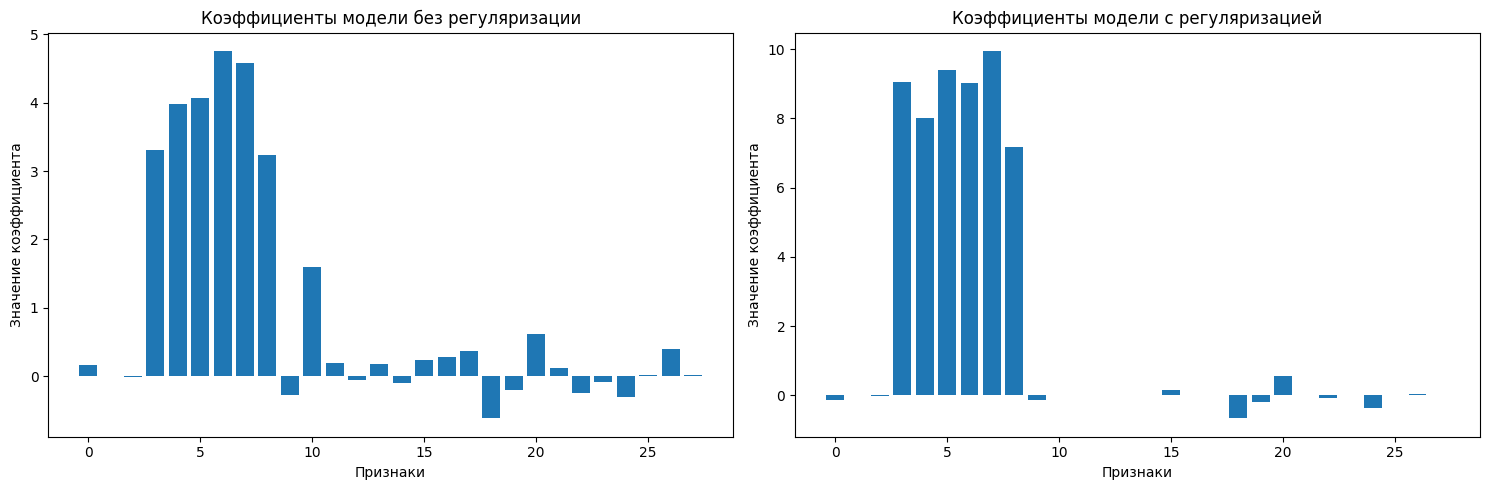

In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
import numpy as np
import matplotlib.pyplot as plt

# Обучаем модель без регуляризации
model_no_penalty = LogisticRegression(solver='lbfgs', max_iter=1000)
model_no_penalty.fit(X_processed, Y)

# Выводим коэффициенты модели без регуляризации
coefficients_no_penalty = model_no_penalty.coef_
print("Коэффициенты модели без регуляризации:", coefficients_no_penalty)

# Инициализируем модель с L1-регуляризацией
model_with_penalty = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)

# Обучаем модель с регуляризацией
model_with_penalty.fit(X_processed, Y)

# Выводим коэффициенты модели с регуляризацией
coefficients_with_penalty = model_with_penalty.coef_
print("Коэффициенты модели с регуляризацией:", coefficients_with_penalty)

# Используем SelectFromModel для отбора признаков
selector = SelectFromModel(model_with_penalty, prefit=True)
X_embedded = selector.transform(X_processed)

# Получаем список отобранных признаков
selected_features = X_processed.columns[selector.get_support()]
print("Отобранные признаки:", selected_features)

# Обучаем модель на отобранных признаках
model_embedded = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
model_embedded.fit(X_embedded, Y)

# Выводим коэффициенты модели после отбора признаков
coefficients_embedded = model_embedded.coef_
print("Коэффициенты модели после отбора признаков:", coefficients_embedded)

# Визуализация коэффициентов моделей
plt.figure(figsize=(15, 5))

# Коэффициенты модели без регуляризации
plt.subplot(1, 2, 1)
plt.bar(range(len(coefficients_no_penalty[0])), coefficients_no_penalty[0])
plt.title("Коэффициенты модели без регуляризации")
plt.xlabel("Признаки")
plt.ylabel("Значение коэффициента")

# Коэффициенты модели с регуляризацией
plt.subplot(1, 2, 2)
plt.bar(range(len(coefficients_with_penalty[0])), coefficients_with_penalty[0])
plt.title("Коэффициенты модели с регуляризацией")
plt.xlabel("Признаки")
plt.ylabel("Значение коэффициента")

plt.tight_layout()
plt.show()

In [73]:
# Преобразуем X_embedded в DataFrame
X_embedded_df = pd.DataFrame(X_embedded, columns=selected_features)

# Обучаем и оцениваем модель
model = train_and_evaluate(X_embedded_df, Y)


Точность на обучающей выборке: 0.9531
Точность на тестовой выборке: 0.9250

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       111
           1       1.00      0.76      0.86        49

    accuracy                           0.93       160
   macro avg       0.95      0.88      0.90       160
weighted avg       0.93      0.93      0.92       160



### ⏰ **Проэксперементировать с разным количеством k, найти лучшую модель, объяснить результат**

Лучшая модель при k равном 7. Но вот прикол в том, что значение при изначальном обучении и этим методом, но в тестовой выборке и так хуже. Чем больше разбиваес на признаки тем лучше. Только если не начинать искать несуществующие. В данном случае - k = 8 добавляет несуществующий признак и результат падает

### ⏰ **Изучить метод отбора ```SequentialFeatureSelector```, описать способ работы, сравнить результат с прошлыми методами и объяснить полученный результат**

Этот метод выдал лучший результат. Отрегулировал выборку, сделав её более нормализованной, некоторые выбросы "отлетели" полностью, что способствовало лучшему качеству выборки. В принципе данный метод подбирает лучшую функцию для вставки и удаления данных. Качественная очистка и вставка данных явно способствует обучению. Просто напросто - чем данные чище, тем обучаемость лучше.

## Логистическая регрессия

**Логистическая регрессия** — это модель для задач бинарной классификации, которая предсказывает вероятность того, что наблюдение принадлежит к одному из двух классов (например, 0 или 1). Модель основана на линейной регрессии, но использует **сигмоидную функцию активации** для приведения предсказаний в диапазон от 0 до 1. Логистическая регрессия идеально подходит для задач, где нужно классифицировать данные на два класса.


#### Принцип работы логистической регрессии:
1. Сначала вычисляется линейная комбинация признаков с весами:  
y = b + w1 * x1 + w2 * x2 + w(n) * x(n), где

x - переменные

w - веса (коэфициенты регресси)

b - смещение

Затем результат линейной комбинации передается в сигмоидную функцию активации, которая преобразует результат в значение от 0 до 1.

### Функция активации (Сигмоида)
**Сигмоидная функция** в логистической регрессии используется для преобразования линейной комбинации признаков в вероятность, что наблюдение относится к классу 1. Формула сигмоиды:

sigmoida = 1 / (1 + e^-y)

Она всегда возвращает значение в диапазоне от 0 до 1, что удобно для интерпретации как вероятность принадлежности к классу 1.

Принцип работы:
1. Инициализация весов: Изначально все веса устанавливаются в нули.

2. Градиентный спуск: На каждой итерации:
- Вычисляется линейная комбинация признаков.
- Применяется сигмоидная функция для предсказания вероятностей.
- Градиенты вычисляются для обновления весов и смещения, минимизируя ошибку.

Предсказание: Для новых данных модель возвращает вероятность, которая затем конвертируется в классы 0 или 1.

In [113]:
import numpy as np

# Сигмоидная функция
def sigmoid(z):
    # Убедимся, что z это numpy массив
    return 1 / (1 + np.exp(-z))

# Простая реализация логистической регрессии
class OwnLogisticRegression:
    def __init__(self, learning_rate=0.01, iterations=1000):
        self.learning_rate = learning_rate
        self.iterations = iterations

    # Метод для обучения модели
    def fit(self, X, y):
        # Инициализация весов
        self.weights = np.zeros(X.shape[1])
        self.bias = 0

        # Градиентный спуск
        for idx_,_ in enumerate(range(self.iterations)):
            # Линейная комбинация
            linear_model = np.dot(X, self.weights) + self.bias
            # Применяем сигмоиду для предсказания
            y_pred = sigmoid(linear_model)

            # Вычисляем градиенты
            dw = (1 / len(X)) * np.dot(X.T, (y_pred - y))
            db = (1 / len(X)) * np.sum(y_pred - y)

            # Обновляем веса и смещение
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    # Метод для предсказания
    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        print("regression",linear_model)
        y_pred = sigmoid(linear_model)
        print("sigmoid",y_pred)
        # Возвращаем метки классов (0 или 1)
        return [1 if i > 0.5 else 0 for i in y_pred]


In [114]:
# Пример использования
X = np.array([[0.1, 1.2], [1.1, 2.2], [2.1, 1.9], [1.0, 1.0]])
y = np.array([0, 1, 1, 0])

model = OwnLogisticRegression(learning_rate=0.1, iterations=1000)
model.fit(X, y)
predictions = model.predict(X)



regression [-2.48902698  1.89302513  3.0459193  -1.27754449]
sigmoid [0.07663102 0.86910007 0.95460602 0.2179685 ]


### ⏰ Вопрос о принципе работы регресси будет в первом теоретическом модуле, важно понимание как оно работает

## 5: Кросс-валидация

**Кросс-валидация** — это метод оценки качества моделей машинного обучения, который помогает избежать переобучения и получить более надежную оценку. Она заключается в разделении данных на несколько частей и обучении модели на различных подмножествах данных, чтобы проверить ее способность обобщать на новых данных.

Основные цели кросс-валидации:

Проверить, насколько хорошо модель будет работать на новых данных.
Определить, есть ли у модели проблемы с переобучением (overfitting) или недообучением (underfitting).
Помочь выбрать наилучшую модель или гиперпараметры.

#### Виды кросс-валидации
1. K-fold Cross-Validation:

Данные делятся на K равных частей (folds). Модель обучается на K-1 частях и тестируется на оставшейся части. Процесс повторяется K раз, и результат — среднее качество по всем K итерациям.
Этот метод позволяет эффективно использовать все данные как для обучения, так и для тестирования.

2. ShuffleSplit:

Этот метод несколько раз случайно перемешивает данные и делит их на тренировочные и тестовые выборки. В отличие от K-fold, здесь нет необходимости в разделении на фиксированное количество частей.
Хорошо работает на небольших выборках данных и для оценки стабильности модели.

3. Train-Test-Validation Split:

Данные делятся на три части: тренировочные данные для обучения модели, тестовые данные для первичной оценки и валидационные данные для окончательной оценки.
Полезен для задач, где требуется как тестирование, так и финальная проверка на отложенных данных.

In [115]:
# Импорт необходимых библиотек
import numpy as np
from sklearn.model_selection import KFold, ShuffleSplit, train_test_split, cross_val_score

In [128]:
# K-Fold Cross-Validation
def k_fold_cross_validation(X, y, n_splits=20):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []

    # Реализация K-Fold вручную
    for train_index, test_index in kf.split(X):
        model = LogisticRegression(max_iter=1000)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Обучение модели на тренировочной выборке
        model.fit(X_train, y_train)

        # Предсказания на тестовой выборке
        y_pred = model.predict(X_test)

        # Оценка точности
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    # Выводим среднюю точность и точности по каждому фолду
    print(f"K-Fold Cross-Validation - Средняя точность: {np.mean(accuracies)}")
    print(f"Точности по каждому фолду: {accuracies}")

# Пример использования:
k_fold_cross_validation(X = X_processed.to_numpy(), y = Y.to_numpy())


K-Fold Cross-Validation - Средняя точность: 0.9187499999999998
Точности по каждому фолду: [0.875, 0.9, 0.85, 0.925, 0.9, 0.8, 0.925, 0.95, 0.975, 0.825, 0.925, 0.975, 0.975, 0.925, 0.925, 0.975, 0.95, 0.9, 0.95, 0.95]


### ⏰ **Используем результат отбора признаков (выбираем по наилучшей точности), делаем кросс валидацию и объясняем результат + перебираем параметры n_splits**

Тут такая странность, что при равном n_splits результаты будут разными, поэтому я ничего не буду говорить, так как каждый раз выдает новое значение. Из-за этого не могу судить

In [164]:
# ShuffleSplit Cross-Validation
def shuffle_split_cross_validation(X, y, n_splits=6, test_size=0.4):
    ss = ShuffleSplit(n_splits=n_splits, test_size=test_size)
    accuracies = []

    # Реализация ShuffleSplit вручную
    for train_index, test_index in ss.split(X):
        model = LogisticRegression(max_iter=1000)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Обучение модели на тренировочной выборке
        model.fit(X_train, y_train)

        # Предсказания на тестовой выборке
        y_pred = model.predict(X_test)

        # Оценка точности
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    # Выводим среднюю точность и точности по каждому разделению
    print(f"ShuffleSplit Cross-Validation - Средняя точность: {np.mean(accuracies)}")
    print(f"Точности по каждому разделению: {accuracies}")

# Пример использования:
shuffle_split_cross_validation(X_processed.to_numpy(), Y.to_numpy())


ShuffleSplit Cross-Validation - Средняя точность: 0.8953125000000001
Точности по каждому разделению: [0.890625, 0.9, 0.9125, 0.884375, 0.88125, 0.903125]


### ⏰ **Используем результат отсечения выбросов, делаем кросс валидацию и объясняем результат + перебираем параметры n_splits**

In [165]:
# Train-Test-Validation Split
def train_test_validation_split(X, y):
    model = LogisticRegression(max_iter=1000)
    # Разделяем данные на тренировочные и оставшиеся (валидация + тест)
    X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)

    # Разделяем оставшиеся данные на валидационные и тестовые
    X_train_train, X_test, y_train_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Обучаем модель на тренировочных данных
    model.fit(X_train_train, y_train_train)

    # Оцениваем на валидационных данных
    y_valid_pred = model.predict(X_validation)
    validation_accuracy = accuracy_score(y_validation, y_valid_pred)
    print(f"Точность на валидационных данных: {validation_accuracy}")

    # Оцениваем на тестовых данных
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Точность на тестовых данных: {test_accuracy}")

# Пример использования:
train_test_validation_split(X_processed.to_numpy(), Y.to_numpy())


Точность на валидационных данных: 0.875
Точность на тестовых данных: 0.8828125


### ⏰ **Используем результат отсечения выбросов или лучший отбор признаков, делаем кросс валидацию и объясняем результат + перебираем параметры n_splits**

### Когда использовать каждый метод:
- K-fold Cross-Validation: Отлично подходит для более точной оценки модели, особенно на небольших наборах данных. Используется, когда нужно получить стабильную оценку по всем данным.

- ShuffleSplit Cross-Validation: Хорошо работает на небольших выборках, где нужно много раз случайно перемешивать и проверять модель. Это может помочь увидеть, как модель работает на различных случайных подвыборках данных.

- Train-Test-Validation Split: Используется, когда нужно четко разделить данные для обучения, подбора параметров и финальной оценки. Подходит для больших наборов данных, где важно иметь отложенную тестовую выборку для окончательной проверки.

### ⏰ **Объяснить, какой из методов подходит для вашего датасета**

Для моего датасета, наверно, больше всего подойдёт k-fold. Нужно лишь узнать - какое количество уникальных значений для типов покемонов. И я говорь не только тип 1, но и тип 2 - разбить на количество таких сочетаний, либо просто по первому типу. Так мы разобьем выборку на разные типы покемонов и сможем обучать каждого "отдельно". Это нам даёт хороший просмотр, например, для выбора, банально, покемонов в каждом типе. Каждый вид ориентирован на что-то своё, поэтому нельзя высматривать лучшего среди всех. На каждый тип есть контрмера вдругом.